[I 2025-05-18 23:15:20,216] A new study created in memory with name: no-name-f4834483-f374-4890-b724-4e922aaafd82
[I 2025-05-18 23:15:23,085] Trial 0 finished with value: 0.6822006639178432 and parameters: {'iterations': 181, 'depth': 4, 'learning_rate': 0.04503544919506949, 'l2_leaf_reg': 13.293461220095022, 'grow_policy': 'SymmetricTree'}. Best is trial 0 with value: 0.6822006639178432.
[I 2025-05-18 23:15:30,977] Trial 1 finished with value: 0.6848116146583154 and parameters: {'iterations': 581, 'depth': 4, 'learning_rate': 0.02891560942812798, 'l2_leaf_reg': 16.621031559479352, 'grow_policy': 'SymmetricTree'}. Best is trial 1 with value: 0.6848116146583154.


Лучшие параметры: {'iterations': 581, 'depth': 4, 'learning_rate': 0.02891560942812798, 'l2_leaf_reg': 16.621031559479352, 'grow_policy': 'SymmetricTree'}
0:	learn: 1.9385136	total: 17.8ms	remaining: 10.3s
100:	learn: 1.7690739	total: 1.31s	remaining: 6.25s
200:	learn: 1.7447906	total: 2.6s	remaining: 4.92s
300:	learn: 1.7289453	total: 3.83s	remaining: 3.56s
400:	learn: 1.7162480	total: 5.04s	remaining: 2.26s
500:	learn: 1.7051983	total: 6.36s	remaining: 1.01s
580:	learn: 1.6967435	total: 7.46s	remaining: 0us

ROC AUC на тесте (OvR): 0.6883

Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.49      0.45      3034
           1       0.41      0.38      0.39      3551
           2       0.23      0.12      0.16      2019
           3       0.21      0.19      0.20      1606
           4       0.25      0.29      0.27      1652
           5       0.21      0.14      0.17      1093
           6       0.20      0.36      0.25      1

/var/folders/7z/21k40hrn1mq8jb3z68kvjrbh0000gn/T/ipykernel_9538/2610966661.py:157: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Split', y='ROC AUC (OvR)', data=metric_comparison, palette='viridis')


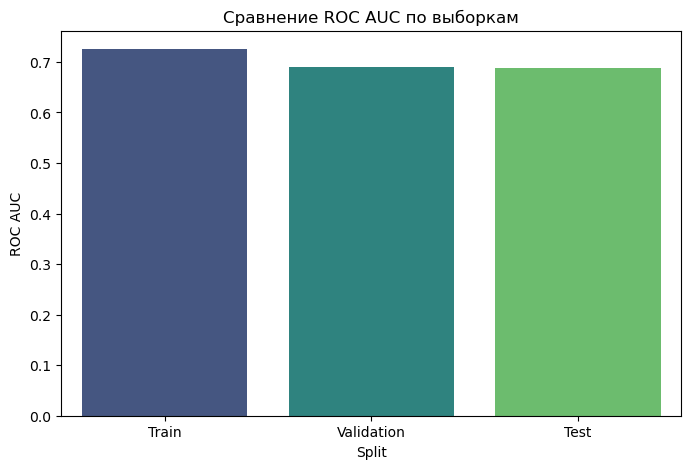

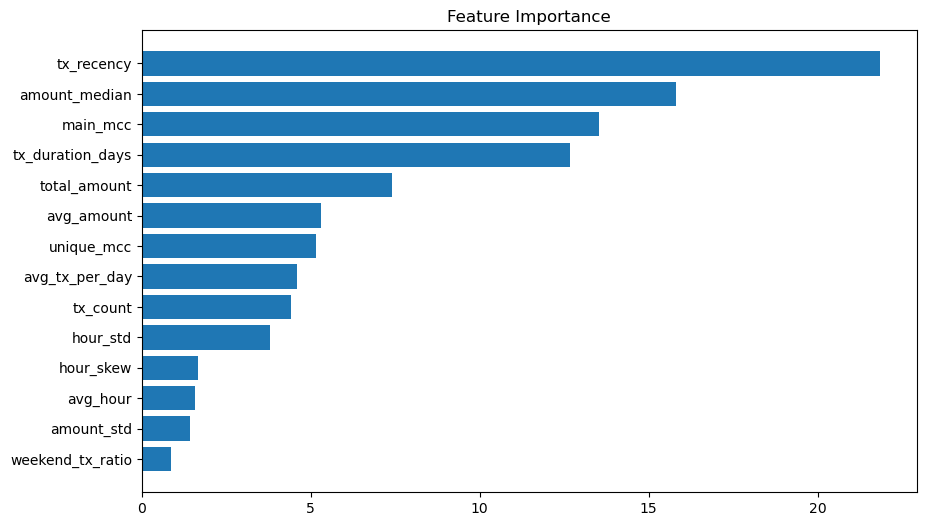

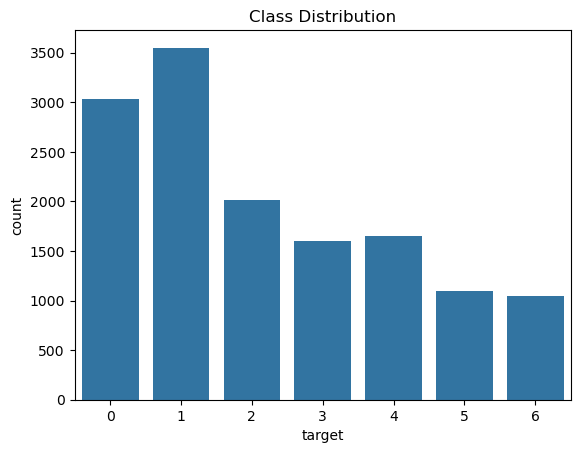

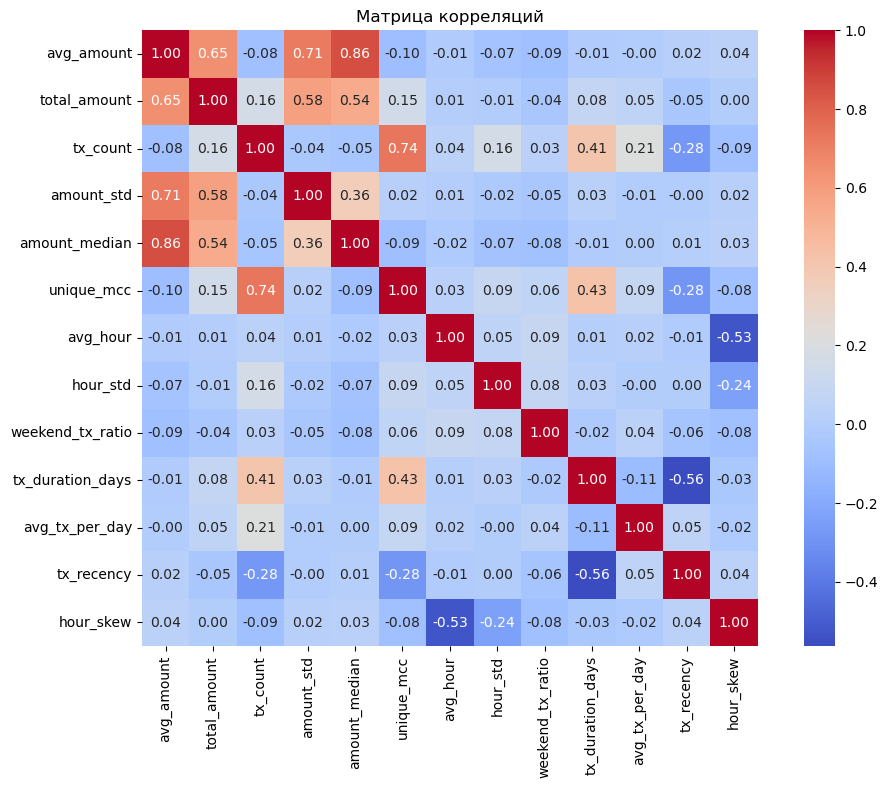

Признаки для удаления из-за высокой корреляции: ['amount_median']
0:	learn: 1.9389690	total: 23.6ms	remaining: 13.7s
100:	learn: 1.7819559	total: 1.47s	remaining: 6.99s
200:	learn: 1.7577165	total: 2.81s	remaining: 5.3s
300:	learn: 1.7426657	total: 4.14s	remaining: 3.85s
400:	learn: 1.7301697	total: 5.5s	remaining: 2.47s
500:	learn: 1.7177551	total: 6.78s	remaining: 1.08s
580:	learn: 1.7094875	total: 7.79s	remaining: 0us


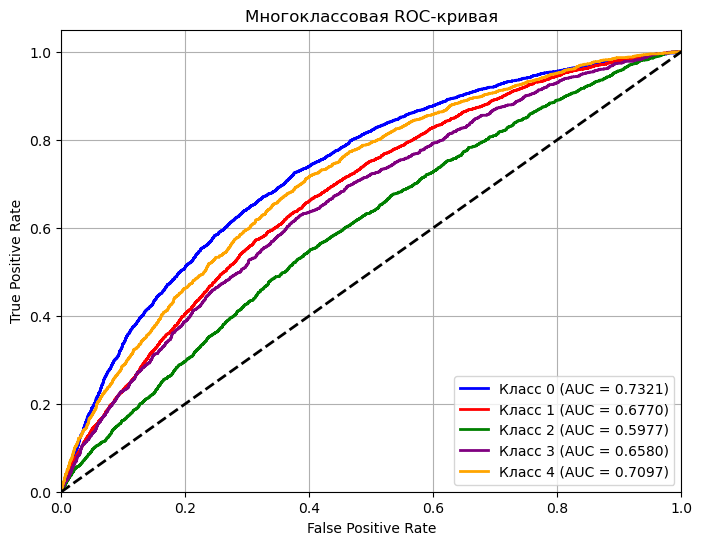


Новый ROC AUC на val (OvR): 0.6852
Новый ROC AUC на тесте (OvR): 0.6815

Финальный submission сохранен как submission_improved.csv


In [ ]:
# --- Импорты ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
import optuna
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# --- Загрузка данных ---
train_transactions = pd.read_parquet('Dataset/train_transactions.parquet')
train_target = pd.read_csv('Dataset/train_target.csv')
test_transactions = pd.read_parquet('Dataset/test_transactions.parquet')

# --- Конвертация даты ---
train_transactions['date_time'] = pd.to_datetime(train_transactions['date_time'])
test_transactions['date_time'] = pd.to_datetime(test_transactions['date_time'])

# --- Функция создания признаков ---
def create_features(df):
    df = df.copy()
    df['hour'] = df['date_time'].dt.hour
    df['day_of_week'] = df['date_time'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

    features = df.groupby('client_num').agg({
        'amount': ['mean', 'sum', 'count', 'std', 'median'],
        'mcc_code': ['nunique', lambda x: x.mode()[0] if not x.mode().empty else np.nan],
        'hour': ['mean', 'std'],
        'is_weekend': ['mean'],
        'date_time': ['min', 'max']
    }).reset_index()

    features.columns = [
        'client_num', 'avg_amount', 'total_amount', 'tx_count', 'amount_std', 'amount_median',
        'unique_mcc', 'main_mcc',
        'avg_hour', 'hour_std',
        'weekend_tx_ratio',
        'first_tx_date', 'last_tx_date'
    ]

    features['tx_duration_days'] = (features['last_tx_date'] - features['first_tx_date']).dt.days.replace(0, 1)
    features['avg_tx_per_day'] = features['tx_count'] / features['tx_duration_days']
    features['tx_recency'] = (pd.to_datetime('today') - features['last_tx_date']).dt.days

    hour_skew = df.groupby('client_num')['hour'].skew().reset_index(name='hour_skew')
    features = features.merge(hour_skew, on='client_num', how='left')

    return features

# --- Разделение клиентов ---
all_clients = train_transactions['client_num'].unique()
clients_train_val, clients_test = train_test_split(all_clients, test_size=0.2, random_state=42)
clients_train, clients_val = train_test_split(clients_train_val, test_size=0.2, random_state=42)

# --- Фильтрация транзакций по клиентам ---
train_df = train_transactions[train_transactions['client_num'].isin(clients_train)]
val_df = train_transactions[train_transactions['client_num'].isin(clients_val)]
test_df = train_transactions[train_transactions['client_num'].isin(clients_test)]

# --- Построение признаков по частям ---
train_features = create_features(train_df)
val_features = create_features(val_df)
test_features = create_features(test_df)

# --- Объединение с целевой переменной ---
train_target_all = train_target.set_index('client_num')
train_features = train_features.merge(train_target_all, on='client_num', how='inner')
val_features = val_features.merge(train_target_all, on='client_num', how='inner')
test_features = test_features.merge(train_target_all, on='client_num', how='inner')

# --- Подготовка X и y ---
X_train = train_features.drop(['client_num', 'target', 'first_tx_date', 'last_tx_date'], axis=1)
y_train = train_features['target']

X_val = val_features.drop(['client_num', 'target', 'first_tx_date', 'last_tx_date'], axis=1)
y_val = val_features['target']

X_test = test_features.drop(['client_num', 'target', 'first_tx_date', 'last_tx_date'], axis=1)
y_test = test_features['target']

# --- Масштабирование ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# --- Балансировка только на трейне ---
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train_scaled, y_train)

# --- Оптимизация гиперпараметров ---
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "depth": trial.suggest_int("depth", 3, 6),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 5, 20),
        "grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree"]),
        "early_stopping_rounds": 20,
        "verbose": False,
        "loss_function": "MultiClass"
    }

    model = CatBoostClassifier(**params)
    model.fit(X_res, y_res, eval_set=(X_val_scaled, y_val))
    y_pred = model.predict_proba(X_val_scaled)
    return roc_auc_score(y_val, y_pred, multi_class='ovo')

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=2)

print("Лучшие параметры:", study.best_params)

# --- Обучение финальной модели ---
best_params = study.best_params
best_params["loss_function"] = "MultiClass"
best_model = CatBoostClassifier(**best_params, verbose=100)
best_model.fit(X_res, y_res)

# --- Сохранение модели и скалера ---
joblib.dump(best_model, "best_model.pkl")
joblib.dump(scaler, "scaler.pkl")

# --- Предсказание на тесте ---
test_pred = best_model.predict(X_test_scaled)
test_pred_proba = best_model.predict_proba(X_test_scaled)

# --- ROC AUC на тесте ---
try:
    test_roc_auc_ovr = roc_auc_score(y_test, test_pred_proba, multi_class='ovr')
    print(f"\nROC AUC на тесте (OvR): {test_roc_auc_ovr:.4f}")
except Exception as e:
    print("Ошибка при подсчёте ROC AUC на тесте:", e)

# --- Classification Report ---
print("\nClassification Report:")
print(classification_report(y_test, test_pred))

# --- Сравнение метрик между выборками ---
y_train_pred_proba = best_model.predict_proba(X_res)
train_roc_auc_ovr = roc_auc_score(y_res, y_train_pred_proba, multi_class='ovr')
val_roc_auc_ovr = roc_auc_score(y_val, best_model.predict_proba(X_val_scaled), multi_class='ovr')

metric_comparison = pd.DataFrame({
    'Split': ['Train', 'Validation', 'Test'],
    'ROC AUC (OvR)': [train_roc_auc_ovr, val_roc_auc_ovr, test_roc_auc_ovr]
})
print("\nСравнение ROC AUC по выборкам:")
print(metric_comparison)

plt.figure(figsize=(8, 5))
sns.barplot(x='Split', y='ROC AUC (OvR)', data=metric_comparison, palette='viridis')
plt.title('Сравнение ROC AUC по выборкам')
plt.ylabel('ROC AUC')
plt.savefig("roc_auc_comparison.png")
plt.show()

# --- Важность признаков ---
feature_importance = best_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), X_train.columns[sorted_idx])
plt.title("Feature Importance")
plt.savefig("feature_importance.png")
plt.show()

# --- Распределение классов графически ---
sns.countplot(x=y_test)
plt.title("Class Distribution")
plt.savefig("class_distribution.png")
plt.show()

# --- Проверка корреляции признаков ---
corr_matrix = X_train.corr(numeric_only=True)  # Для версии pandas < 2.0 убери numeric_only
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Матрица корреляций")
plt.savefig("correlation_matrix.png")
plt.show()

# --- Удаление сильно скоррелированных признаков ---
threshold = 0.8
upper = corr_matrix.abs().where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print("Признаки для удаления из-за высокой корреляции:", to_drop)

# Удаляем сильно скоррелированные признаки
X_train = X_train.drop(columns=to_drop, errors='ignore')
X_val = X_val.drop(columns=to_drop, errors='ignore')
X_test = X_test.drop(columns=to_drop, errors='ignore')

# Пересчитываем масштабирование
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Балансировка заново
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train_scaled, y_train)

# Переобучаем модель
best_model = CatBoostClassifier(**best_params, verbose=100)
best_model.fit(X_res, y_res)

# Новые предсказания
y_val_pred_proba = best_model.predict_proba(X_val_scaled)
y_test_pred_proba = best_model.predict_proba(X_test_scaled)

# --- График ROC AUC для многоклассовой классификации ---
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Бинаризуем целевую переменную
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

# Вычисляем ROC и AUC для каждого класса
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], test_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Построение графика
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green', 'purple', 'orange'][:n_classes]
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='Класс {0} (AUC = {1:0.4f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Многоклассовая ROC-кривая')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig("multi_class_roc_curve.png")
plt.show()

# --- Новые метрики ---
new_val_roc_auc = roc_auc_score(y_val, y_val_pred_proba, multi_class='ovr')
new_test_roc_auc = roc_auc_score(y_test, y_test_pred_proba, multi_class='ovr')

print(f"\nНовый ROC AUC на val (OvR): {new_val_roc_auc:.4f}")
print(f"Новый ROC AUC на тесте (OvR): {new_test_roc_auc:.4f}")



# --- Submission для теста ---
X_test_full = test_transactions
test_features_final = create_features(X_test_full)
X_test_final = test_features_final.drop(['client_num', 'first_tx_date', 'last_tx_date'], axis=1)

# Удаление тех же признаков из тестового набора
X_test_final = X_test_final.drop(columns=to_drop, errors='ignore')

X_test_final_scaled = scaler.transform(X_test_final)
final_predictions = best_model.predict(X_test_final_scaled)

submission = pd.DataFrame({
    'client_num': test_features_final['client_num'],
    'target': final_predictions.flatten()
})
submission.to_csv('submission_improved.csv', index=False)
print("\nФинальный submission сохранен как submission_improved.csv")